In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#%pip install --upgrade dask distributed dask_ml

In [ ]:
from pathlib import Path
import sys
module_path = Path("..").resolve().as_posix()
if module_path not in sys.path:
    print(f"Adding {module_path} to python path")
    sys.path.append(module_path)

In [ ]:
import lib.io.pysnptools_backend
from lib.method.pc_relate.pc_relate import pc_relate

In [ ]:
from lib import api
import pandas as pd
import numpy as np
from dask_ml.decomposition import PCA
import dask
import dask.array as da
import seaborn as sns
import time
from distributed import Client
import timeit
from dataclasses import dataclass
import gc

In [ ]:
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
from IPython.core.pylabtools import figsize
figsize(14, 7)
dot_size=50

## Dask client

In [ ]:
c = Client(processes=True, n_workers=2, threads_per_worker=4)
c

## Util functions

In [8]:
@dataclass
class Measurement:
    samples: int
    variants: int
    populations: int
    walltime: int
        
    def to_csv(self) -> str:
        return f"{self.samples},{self.variants},{self.populations},{self.walltime:.2f}"

In [9]:
def compute_pca(g, display_pc_12: bool=True):
    pca = PCA(n_components=8, random_state=42)
    pca.fit(g)
    if display_pc_12:
        display(sns.scatterplot(x=pca.components_[0], y=pca.components_[1]))
    pcs = da.from_array(pca.components_)
    return pcs[:2,:]

In [10]:
def get_plink(samples: int, variants: int, population: int) -> dask.array:
    # This data was generated via hail using Balding-Nichols model
    #path = Path(f"{Path.home()}/data/tmp/mt_{samples}_{variants}_{population}.mt/data").as_posix()
    path = Path(f"{Path.home()}/projects/tmp/mt_{samples}_{variants}_{population}.mt/data").as_posix()
    ds = api.read_plink(path, chunks='auto', fam_sep=' ', bim_sep='\t')
    return ds.data.data

In [11]:
def run_experiment(samples: int, variants: int, population: int, f_times) -> None:
    g = get_plink(samples=samples, variants=variants, population=population)
    pcs = compute_pca(g, False)
    g = g.persist()
    pcs = pcs.persist()
    t_0 = timeit.default_timer()
    pc_relate_results = pc_relate(pcs, g, maf=0.0).compute()
    dur = timeit.default_timer() - t_0
    m = Measurement(samples=samples, variants=variants, populations=population, walltime=dur)
    f_times.write(f"{m.to_csv()}\n")
    f_times.flush()
    print(f"s: {samples}, v: {variants} -> {dur:.2f} sec")
    del pcs
    del g
    del pc_relate_results
    gc.collect()

In [12]:
from scipy.optimize import curve_fit

def pc_relate_time(X, a, b, c):
    s,v = X
    return a*v*s**2 + b

def fit_pc_relate_comp(e: pd.DataFrame):
    popt, _ = curve_fit(pc_relate_time, (e.samples, e.variants), e.walltime)
    return lambda s, v: pc_relate_time((s, v), *popt)

In [13]:
def draw_walltime_graph(measurments_filepath: str , title: str):
    ms = pd.read_csv(measurments_filepath)
    fitted = fit_pc_relate_comp(ms)
    p = sns.scatterplot(x="samples", y="walltime", data=ms, s=dot_size)
    plt.plot(ms.samples, fitted(ms.samples, ms.variants))
    p.set(ylabel="walltime seconds", title=title)
    return fitted

## Experiments

### Threadpool vs processpool

In [ ]:
with open("times_1_processpool.csv", mode="a") as f_times:
    f_times.write("samples,variants,populations,walltime\n")
    with dask.config.set({"optimization.fuse.ave-width": 20}):
        for s in range(1000, 5001, 200):
            for v in range(1000, 5001, 200):
                run_experiment(samples=s, variants=v, population=10, f_times=f_times)

[Text(0, 0.5, 'walltime seconds'),
 Text(0.5, 1.0, 'pc_relate, threadpool, maf=0')]

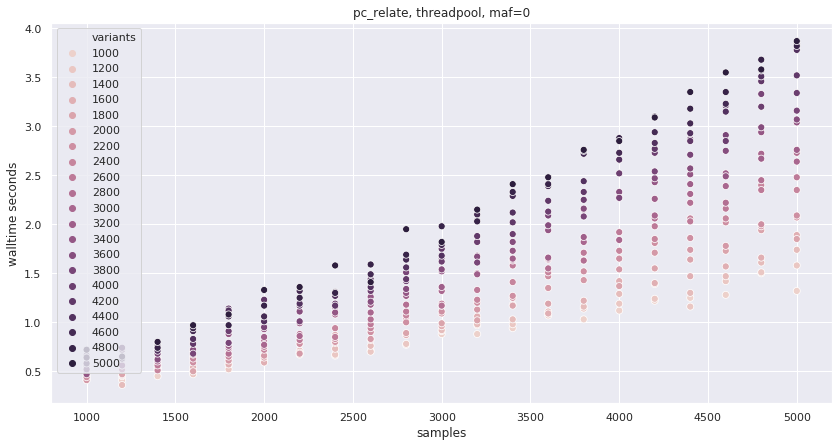

In [39]:
times_cross = pd.read_csv("times_1_threadpool.csv")
p = sns.scatterplot(x="samples", y="walltime", data=times_cross, s=50, hue="variants", legend="full")
p.set(ylabel="walltime seconds", title="pc_relate, threadpool, maf=0")

In [ ]:
with open("times_constant_variant_2k_processpool_maf_0.csv", mode="a") as f_times:
    f_times.write("samples,variants,populations,walltime\n")
    with dask.config.set({"optimization.fuse.ave-width": 20}):
        for s in range(1000, 10001, 200):
            run_experiment(samples=s, variants=2000, population=10, f_times=f_times)

In [17]:
variant_2k_times_thread = pd.read_csv("times_constant_variant_2k_threadpool_maf_0.csv")
variant_2k_times_process = pd.read_csv("times_constant_variant_2k_processpool_maf_0.csv")

In [19]:
eight_core_vm_thread = fit_pc_relate_comp(variant_2k_times_thread)
eight_core_vm_process = fit_pc_relate_comp(variant_2k_times_process)

/home/rav/anaconda3/envs/gwas-analysis-default/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[Text(0, 0.5, 'walltime seconds'),
 Text(0.5, 1.0, 'pc_relate, const variants=2k, MAF=0.0')]

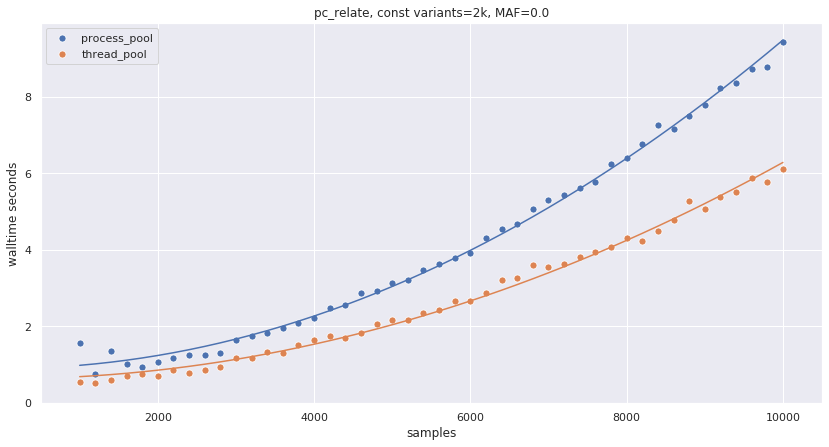

In [20]:
p = sns.scatterplot(x="samples", y="walltime", data=variant_2k_times_process, s=dot_size, label="process_pool")
plt.plot(variant_2k_times_process.samples, eight_core_vm_process(variant_2k_times_process.samples, variant_2k_times_process.variants))
p = sns.scatterplot(x="samples", y="walltime", data=variant_2k_times_thread, s=dot_size, ax=p, label="thread_pool")
plt.plot(variant_2k_times_thread.samples, eight_core_vm_thread(variant_2k_times_thread.samples, variant_2k_times_thread.variants))
p.set(ylabel="walltime seconds", title="pc_relate, const variants=2k, MAF=0.0")

In [27]:
print(f"Based on the curve above, 0.5M samples and 2k variants would take: {eight_core_vm_process(.5e6, 2000)/3600/24:.2f} days on 8 core VM")
#HAIL: 0.5M samples (AND 2000 variants) would take 8.75 days on 8 cores

Based on the curve above, 0.5M samples and 2k variants would take: 0.25 days on 8 core VM


### 1 core experiments

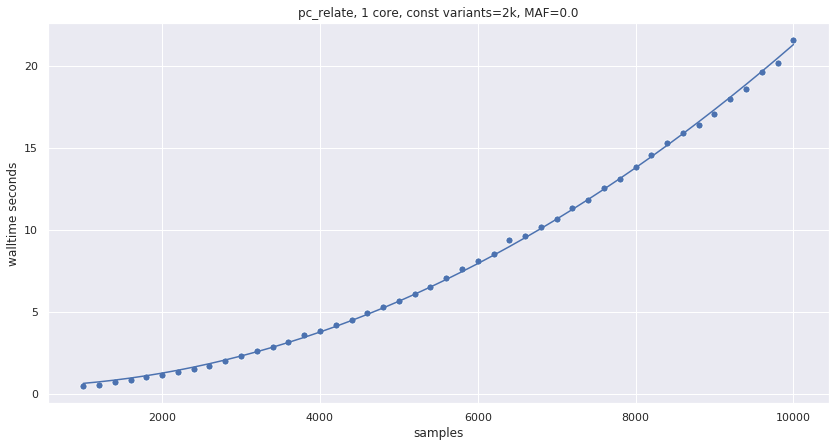

In [27]:
one_core_vm_process = draw_walltime_graph("times_constant_variant_2k_processpool_maf_0_1_core.csv", "pc_relate, 1 core, const variants=2k, MAF=0.0")

In [28]:
print(f"Based on the curve above, 0.5M samples and 2k variants would take: {one_core_vm_process(.5e6, 2000)/3600/24:.2f} days on 1 core VM")
#HAIL: 0.5M samples (AND 2000 variants) would take 36.37 days on a single core

Based on the curve above, 0.5M samples and 2k variants would take: 0.60 days on 1 core VM


In [21]:
e_1_to_5_1_thread_maf_0_1_core = "times_1_to_5_processpool_maf_0_1_core.csv"

In [ ]:
with open(e_1_to_5_1_thread_maf_0_1_core, mode="a") as f_times:
    f_times.write("samples,variants,populations,walltime\n")
    with dask.config.set({"optimization.fuse.ave-width": 20}):
        for s in range(1000, 20001, 500):
            run_experiment(samples=s, variants=int(s * 5), population=10, f_times=f_times)

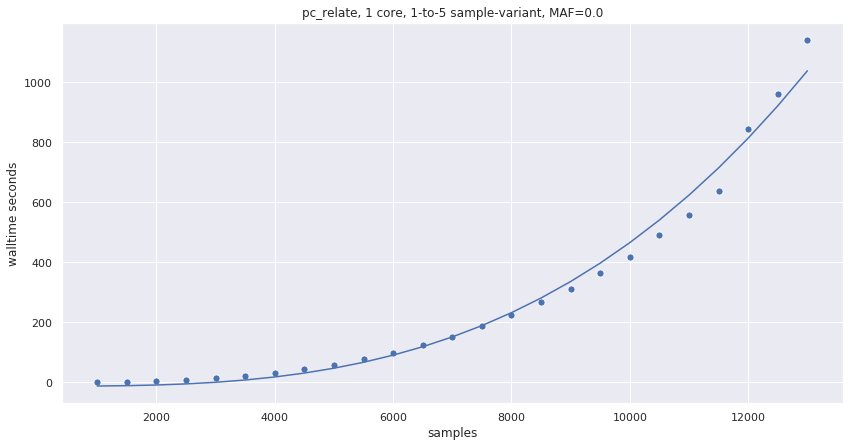

In [29]:
one_core_vm_1_to_5 = draw_walltime_graph(e_1_to_5_1_thread_maf_0_1_core, "pc_relate, 1 core, 1-to-5 sample-variant, MAF=0.0")

In [30]:
print(f"Based on the curve above, 0.5M samples and 2.5M variants would take: {one_core_vm_1_to_5(.5e6, 2.5e6)/3600/24:.2f} days on 1 core VM")
#HAIL: 0.5M samples and 2.5M variants would take 12465.46 days on a single core

Based on the curve above, 0.5M samples and 2.5M variants would take: 691.70 days on 1 core VM


In [20]:
e_1_to_500_processpool_maf_0_1_core = "times_1_to_500_processpool_maf_0_1_core.csv"

In [21]:
with open(e_1_to_500_processpool_maf_0_1_core, mode="a") as f_times:
    f_times.write("samples,variants,populations,walltime\n")
    with dask.config.set({"optimization.fuse.ave-width": 20}):
        for s in range(1000, 2001, 200):
            run_experiment(samples=s, variants=int(s * 500), population=10, f_times=f_times)

s: 1000, v: 500000 -> 67.16 sec
s: 1200, v: 600000 -> 106.75 sec
s: 1400, v: 700000 -> 162.11 sec
s: 1600, v: 800000 -> 261.88 sec
s: 1800, v: 900000 -> 406.11 sec
s: 2000, v: 1000000 -> 658.15 sec


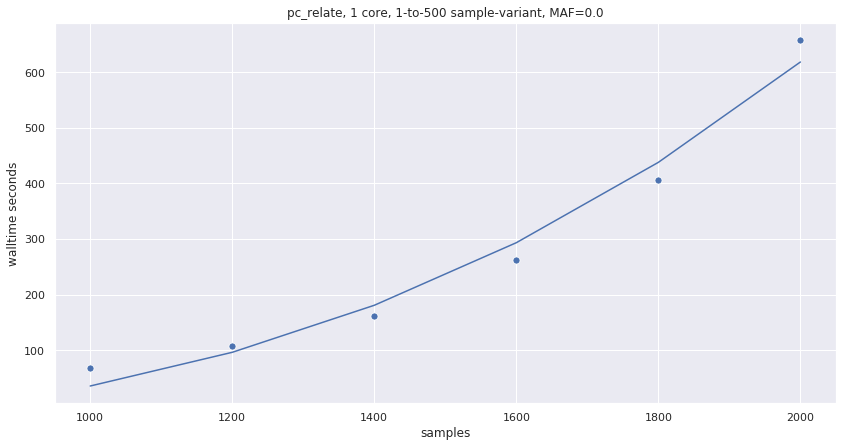

In [33]:
draw_walltime_graph(e_1_to_500_processpool_maf_0_1_core, "pc_relate, 1 core, 1-to-500 sample-variant, MAF=0.0")

## 8 cores experiments

In [14]:
e_1_to_5_processpool_maf_0_8_cores = "times_1_to_5_processpool_2w4t_maf_0_8_cores.csv"

In [ ]:
with open(e_1_to_5_processpool_maf_0_8_cores, mode="a") as f_times:
    f_times.write("samples,variants,populations,walltime\n")
    with dask.config.set({"optimization.fuse.ave-width": 20}):
        for s in range(1000, 20001, 500):
            run_experiment(samples=s, variants=int(s * 5), population=10, f_times=f_times)

s: 1000, v: 5000 -> 0.99 sec
s: 1500, v: 7500 -> 1.55 sec
s: 2000, v: 10000 -> 2.68 sec
s: 2500, v: 12500 -> 3.96 sec


/home/rav/anaconda3/envs/gwas-analysis-default/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


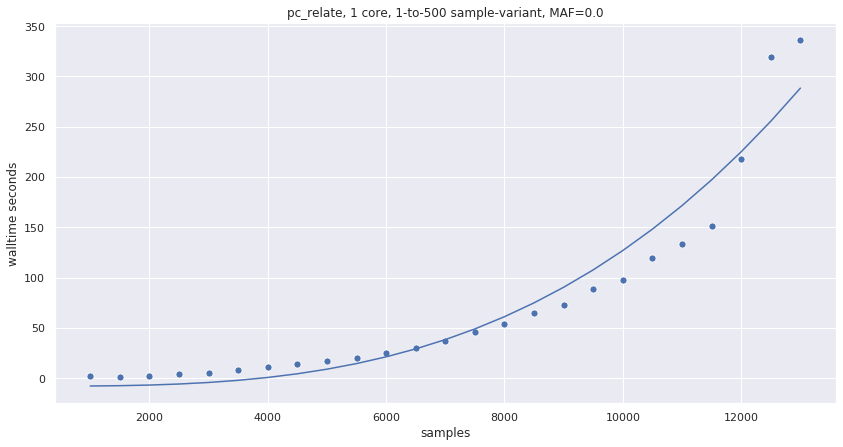

In [16]:
eight_core_vm_1_to_5 = draw_walltime_graph(e_1_to_5_processpool_maf_0_8_cores, "pc_relate, 1 core, 1-to-500 sample-variant, MAF=0.0")

In [17]:
print(f"Based on the curve above, 0.5M samples and 2.5M variants would take: {eight_core_vm_1_to_5(.5e6, 2.5e6)/3600/24:.2f} days on 8 core VM")

Based on the curve above, 0.5M samples and 2.5M variants would take: 195.09 days on 8 core VM


In [18]:
e_1_to_500_processpool_maf_0_8_core = "times_1_to_500_processpool_2w4t_maf_0_8_core.csv"

In [ ]:
with open(e_1_to_500_processpool_maf_0_8_core, mode="a") as f_times:
    f_times.write("samples,variants,populations,walltime\n")
    with dask.config.set({"optimization.fuse.ave-width": 20}):
        for s in range(2000, 2001, 200):
            run_experiment(samples=s, variants=int(s * 500), population=10, f_times=f_times)

/home/rav/anaconda3/envs/gwas-analysis-default/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


<function __main__.fit_pc_relate_comp.<locals>.<lambda>(s, v)>

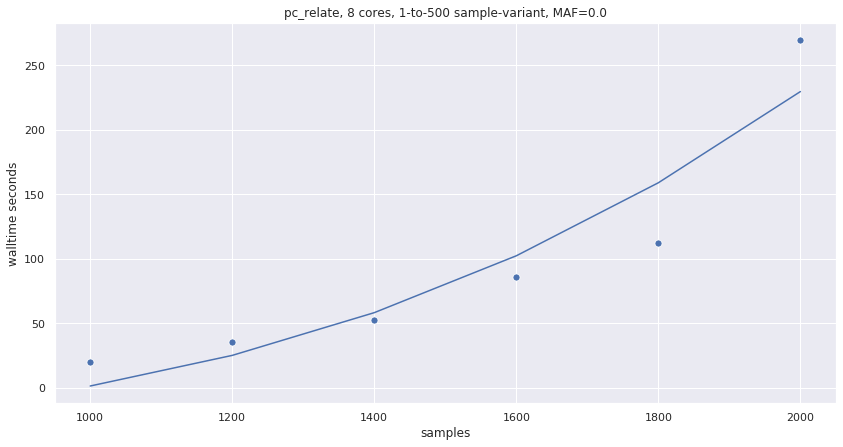

In [17]:
draw_walltime_graph(e_1_to_500_processpool_maf_0_8_core, "pc_relate, 8 cores, 1-to-500 sample-variant, MAF=0.0")